In [1]:
import sys
sys.path.append("../") # adding the path to read the utils file
from sklearnex import patch_sklearn
patch_sklearn(global_patch=True)
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from catboost import CatBoostClassifier
from sklearn import metrics, tree
from shap import TreeExplainer
import fasttreeshap
from shap import plots, Explanation
import graphviz 
from yellowbrick.model_selection import LearningCurve
import time
import shap
from utils import *
import pickle
from yellowbrick.classifier import ROCAUC
from yellowbrick.contrib.wrapper import wrap

pd.set_option('display.max_columns', None)

Scikit-learn was successfully globally patched by Intel(R) Extension for Scikit-learn


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
# you should run making_hikari2022_csv.ipynb before running this cell, since the two csv given with the paper have two differences
# to see what are the data types and the features of the dataset, you can take a look on the utils file
ds = pd.concat([
    pd.read_csv('../datasets/HIKARI-2021/ALLFLOWMETER_HIKARI2021.csv', dtype=dtype_hikari, usecols=selected_features_hikari),
    pd.read_csv('../datasets/HIKARI-2021/ALLFLOWMETER_HIKARI2022.csv', dtype=dtype_hikari, usecols=selected_features_hikari)], 
    ignore_index=True)
ds.head()

,flow_duration,fwd_pkts_tot,bwd_pkts_tot,fwd_data_pkts_tot,bwd_data_pkts_tot,fwd_pkts_per_sec,bwd_pkts_per_sec,flow_pkts_per_sec,down_up_ratio,fwd_header_size_tot,fwd_header_size_min,fwd_header_size_max,bwd_header_size_tot,bwd_header_size_min,bwd_header_size_max,flow_FIN_flag_count,flow_SYN_flag_count,flow_RST_flag_count,fwd_PSH_flag_count,bwd_PSH_flag_count,flow_ACK_flag_count,fwd_URG_flag_count,bwd_URG_flag_count,flow_CWR_flag_count,flow_ECE_flag_count,fwd_pkts_payload.min,fwd_pkts_payload.max,fwd_pkts_payload.tot,fwd_pkts_payload.avg,fwd_pkts_payload.std,bwd_pkts_payload.min,bwd_pkts_payload.max,bwd_pkts_payload.tot,bwd_pkts_payload.avg,bwd_pkts_payload.std,flow_pkts_payload.min,flow_pkts_payload.max,flow_pkts_payload.tot,flow_pkts_payload.avg,flow_pkts_payload.std,fwd_iat.min,fwd_iat.max,fwd_iat.tot,fwd_iat.avg,fwd_iat.std,bwd_iat.min,bwd_iat.max,bwd_iat.tot,bwd_iat.avg,bwd_iat.std,flow_iat.min,flow_iat.max,flow_iat.tot,flow_iat.avg,flow_iat.std,payload_bytes_per_second,fwd_subflow_pkts,bwd_subflow_pkts,fwd_subflow_bytes,bwd_subflow_bytes,fwd_bulk_bytes,bwd_bulk_bytes,fwd_bulk_packets,bwd_bulk_packets,fwd_bulk_rate,bwd_bulk_rate,active.min,active.max,active.tot,active.avg,active.std,idle.min,idle.max,idle.tot,idle.avg,idle.std,fwd_init_window_size,bwd_init_window_size,fwd_last_window_size,traffic_category,Label
0,2.207588,15,14,6,6,6.794746,6.341763,13.136509,0.933333,464,20,40,492,32,44,2,2,2,6,5,26,0,0,0,0,0,742,1826.0,121.733333,220.736581,0,1448,5025.0,358.928571,552.239840,0,1448,6851.0,236.241379,424.859275,18.119812,1.963762e+06,2.207603e+06,1.576859e+05,5.205052e+05,7.867813,2.032929e+06,2.177950e+06,1.675346e+05,5.606267e+05,7.867813,1.963762e+06,2.207603e+06,78842.963491,3.696378e+05,3103.387105,7.5,7.0,913.0,2512.5,0.0,0.0,0.0,0.0,0.0,0.0,2.207603e+06,2.207603e+06,2.207603e+06,2.207603e+06,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,29200,65160,0,Bruteforce-XML,True
1,15.624266,15,14,6,6,0.960045,0.896042,1.856087,0.933333,488,20,44,468,32,44,2,2,2,6,5,26,0,0,0,0,0,745,1829.0,121.933333,221.339257,0,1448,5025.0,358.928571,552.239840,0,1448,6854.0,236.344828,424.987166,20.980835,1.534300e+07,1.562428e+07,1.116020e+06,4.094889e+06,20.980835,1.541144e+07,1.559517e+07,1.199628e+06,4.270148e+06,10.013580,1.534300e+07,1.562428e+07,558009.896960,2.897622e+06,438.676603,7.5,7.0,914.5,2512.5,0.0,0.0,0.0,0.0,0.0,0.0,2.883792e+04,2.524381e+05,2.812760e+05,1.406380e+05,158109.181742,1.534300e+07,1.534300e+07,1.534300e+07,1.534300e+07,0.0,29200,65160,0,Bruteforce-XML,True
2,12.203357,14,13,6,5,1.147225,1.065281,2.212506,0.928571,432,20,40,448,32,44,2,2,2,6,5,24,0,0,0,0,0,744,1828.0,130.571429,226.803444,0,2896,5025.0,386.538462,817.479013,0,2896,6853.0,253.814815,592.570284,36.001205,1.196814e+07,1.220338e+07,9.387216e+05,3.314032e+06,15.020370,1.203674e+07,1.217482e+07,1.014569e+06,3.471107e+06,15.020370,1.196814e+07,1.220338e+07,469360.810060,2.345336e+06,561.566789,7.0,6.5,914.0,2512.5,0.0,0.0,0.0,0.0,0.0,0.0,2.891302e+04,2.063251e+05,2.352381e+05,1.176190e+05,125449.251656,1.196814e+07,1.196814e+07,1.196814e+07,1.196814e+07,0.0,29200,65160,0,Bruteforce-XML,True
3,9.992448,14,13,6,5,1.401058,1.300983,2.702041,0.928571,432,20,40,436,32,44,2,2,2,6,5,24,0,0,0,0,0,744,1828.0,130.571429,226.803444,0,2896,5025.0,386.538462,817.479013,0,2896,6853.0,253.814815,592.570284,50.067902,9.759205e+06,9.992470e+06,7.686515e+05,2.701448e+06,20.980835,9.828447e+06,9.963348e+06,8.302790e+05,2.833716e+06,20.980835,9.759205e+06,9.992470e+06,384325.770231,1.912152e+06,685.817940,7.0,6.5,914.0,2512.5,0.0,0.0,0.0,0.0,0.0,0.0,2.952909e+04,2.037361e+05,2.332652e+05,1.166326e+05,123182.931318,9.759205e+06,9.759205e+06,9.759205e+06,9.759205e+06,0.0,29200,65160,0,Bruteforce-XML,True
4,7.780611,14,14,6,5,1.799345,1.799345,3.598689,1.000000,432,20,40,480,32,44,2,2,2,6,5,25,0,0,0,0,0,744,1828.0,130.571429,226.803444,0,2896,5025.0,358.928571,792.173394,0,2896,6853.0,244.750000,583.468215,16.927719,7.545305e+06,7.780620e+06,5.985092e+

In [3]:
compute_ratio(ds,'traffic_category')

                     Ratio
traffic_category          
Benign               71.77
Background           21.72
Probing               2.98
XMRIGCC CryptoMiner   1.39
Bruteforce-XML        1.12
Bruteforce            1.02


In [4]:
ds['traffic_category'] = np.where(ds['traffic_category'] == 'Background', 'Benign', ds['traffic_category'])

In [5]:
compute_ratio(ds,'traffic_category')

                     Ratio
traffic_category          
Benign               93.49
Probing               2.98
XMRIGCC CryptoMiner   1.39
Bruteforce-XML        1.12
Bruteforce            1.02


In [6]:
params = {
    'iterations': 10, # 80
    'depth': 8, # 7
    'learning_rate': 0.6,
    'loss_function': 'MultiClass',
    'verbose': True
}

cat = CatBoostClassifier(**params)

rus = RandomUnderSampler(random_state=42, sampling_strategy='all')
X_res, y_res = rus.fit_resample(ds[x_features], ds['traffic_category'])

In [7]:
y_res.value_counts()

traffic_category
Benign                 7988
Bruteforce             7988
Bruteforce-XML         7988
Probing                7988
XMRIGCC CryptoMiner    7988
Name: count, dtype: int64

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size = 0.2, random_state=12, shuffle=True, stratify=y_res)

In [9]:
if False:
    cv = 10
    visualizer = LearningCurve(estimator=rf, cv=cv, scoring='f1_weighted', n_jobs=1, random_state=123)
    visualizer.fit(X_res, y_res)
    visualizer.show(outpath="rf_data/learning_curve.png")

In [10]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
skf.get_n_splits(X_res, y_res)

5

In [11]:
avg_train_f1 = []
avg_test_f1 = []

for i, (train_index, test_index) in enumerate(skf.split(X_res, y_res)):
    print(f"Fold {i}:")
    cat.fit(X_res.iloc[train_index], y_res.iloc[train_index])
    y_predicted_train = cat.predict(X_res.iloc[train_index])
    y_predicted_test = cat.predict(X_res.iloc[test_index])
    train_f1 = metrics.f1_score(y_res.iloc[train_index], y_predicted_train, average='weighted')
    test_f1 = metrics.f1_score(y_res.iloc[test_index], y_predicted_test, average='weighted')
    print(f"Train F1: {train_f1:.4f}")
    print(f"Test F1: {test_f1:.4f}")
    avg_train_f1.append(train_f1)
    avg_test_f1.append(test_f1)

print(f"Average Train F1: {np.mean(avg_train_f1):.4f}")
print(f"Average Test F1: {np.mean(avg_test_f1):.4f}")

Fold 0:
0:	learn: 0.3362114	total: 117ms	remaining: 1.05s
1:	learn: 0.2302913	total: 183ms	remaining: 731ms
2:	learn: 0.1760277	total: 245ms	remaining: 572ms
3:	learn: 0.1514547	total: 310ms	remaining: 465ms
4:	learn: 0.1364213	total: 373ms	remaining: 373ms
5:	learn: 0.1289006	total: 438ms	remaining: 292ms
6:	learn: 0.1246084	total: 500ms	remaining: 214ms
7:	learn: 0.1211420	total: 561ms	remaining: 140ms
8:	learn: 0.1192116	total: 625ms	remaining: 69.5ms
9:	learn: 0.1176369	total: 689ms	remaining: 0us
Train F1: 0.9681
Test F1: 0.9633
Fold 1:
0:	learn: 0.3361374	total: 64.1ms	remaining: 576ms
1:	learn: 0.2334971	total: 128ms	remaining: 512ms
2:	learn: 0.1849819	total: 189ms	remaining: 442ms
3:	learn: 0.1553134	total: 253ms	remaining: 379ms
4:	learn: 0.1392263	total: 317ms	remaining: 317ms
5:	learn: 0.1321093	total: 380ms	remaining: 253ms
6:	learn: 0.1278010	total: 442ms	remaining: 189ms
7:	learn: 0.1247701	total: 505ms	remaining: 126ms
8:	learn: 0.1224432	total: 569ms	remaining: 63.2ms


In [12]:
%timeit cat.fit(X_train, y_train)

0:	learn: 0.3397514	total: 65.2ms	remaining: 587ms
1:	learn: 0.2337171	total: 123ms	remaining: 492ms
2:	learn: 0.1811117	total: 191ms	remaining: 447ms
3:	learn: 0.1538133	total: 273ms	remaining: 410ms
4:	learn: 0.1392475	total: 346ms	remaining: 346ms
5:	learn: 0.1317976	total: 407ms	remaining: 272ms
6:	learn: 0.1273610	total: 470ms	remaining: 202ms
7:	learn: 0.1242514	total: 533ms	remaining: 133ms
8:	learn: 0.1213751	total: 594ms	remaining: 66ms
9:	learn: 0.1199709	total: 654ms	remaining: 0us
0:	learn: 0.3397514	total: 60.8ms	remaining: 547ms
1:	learn: 0.2337171	total: 123ms	remaining: 493ms
2:	learn: 0.1811117	total: 184ms	remaining: 428ms
3:	learn: 0.1538133	total: 245ms	remaining: 368ms
4:	learn: 0.1392475	total: 309ms	remaining: 309ms
5:	learn: 0.1317976	total: 369ms	remaining: 246ms
6:	learn: 0.1273610	total: 431ms	remaining: 185ms
7:	learn: 0.1242514	total: 493ms	remaining: 123ms
8:	learn: 0.1213751	total: 556ms	remaining: 61.8ms
9:	learn: 0.1199709	total: 615ms	remaining: 0us
0:

In [13]:
%time y_predicted_train = cat.predict(X_train)
%timeit y_predicted_test = cat.predict(X_test)

CPU times: user 22 ms, sys: 4.89 ms, total: 26.9 ms
Wall time: 8.39 ms
2.59 ms ± 179 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [14]:
performanceMetricsDFWeighted(metrics, y_train, y_predicted_train, y_test, y_predicted_test, 'weighted')

,Measure,Train,Test
0,ACCURACY,0.968734,0.965949
1,PRECISION,0.970415,0.967686
2,RECALL,0.968734,0.965949
3,F1 SCORE,0.967953,0.964990


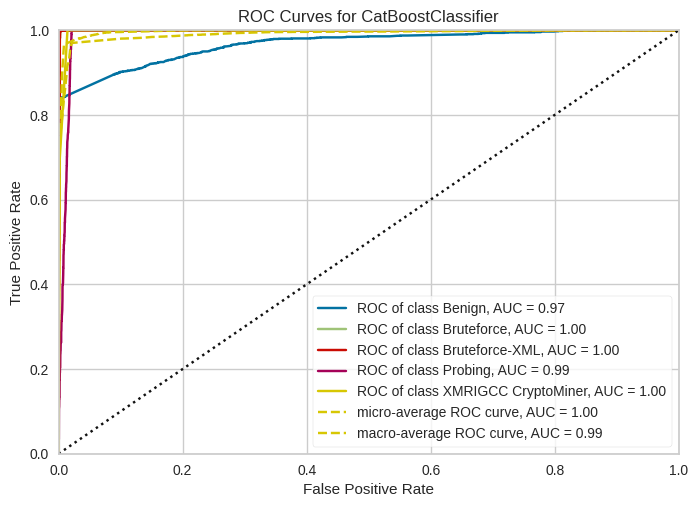

<Axes: title={'center': 'ROC Curves for CatBoostClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [15]:
model = wrap(cat)
visualizer = ROCAUC(model)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()

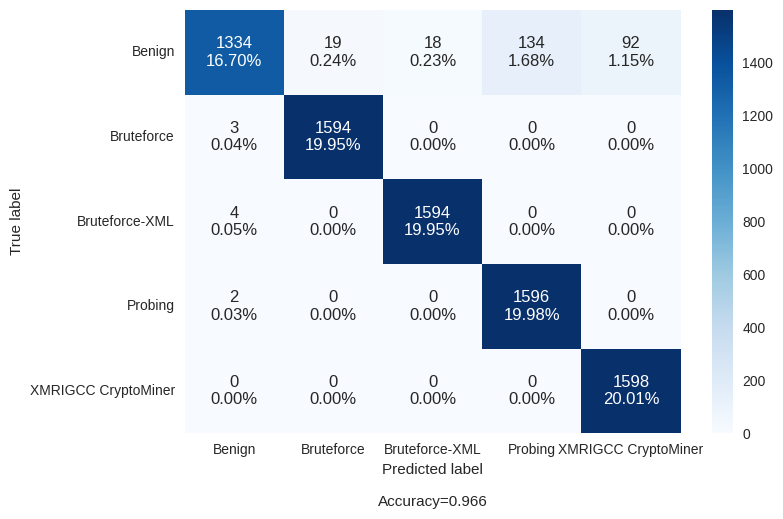

In [16]:
# Show the confusion matrix
cf = metrics.confusion_matrix(y_test,y_predicted_test)
categories = pd.unique(cat.classes_)
make_confusion_matrix(cf, 
                      categories=categories,
                      cmap='Blues')

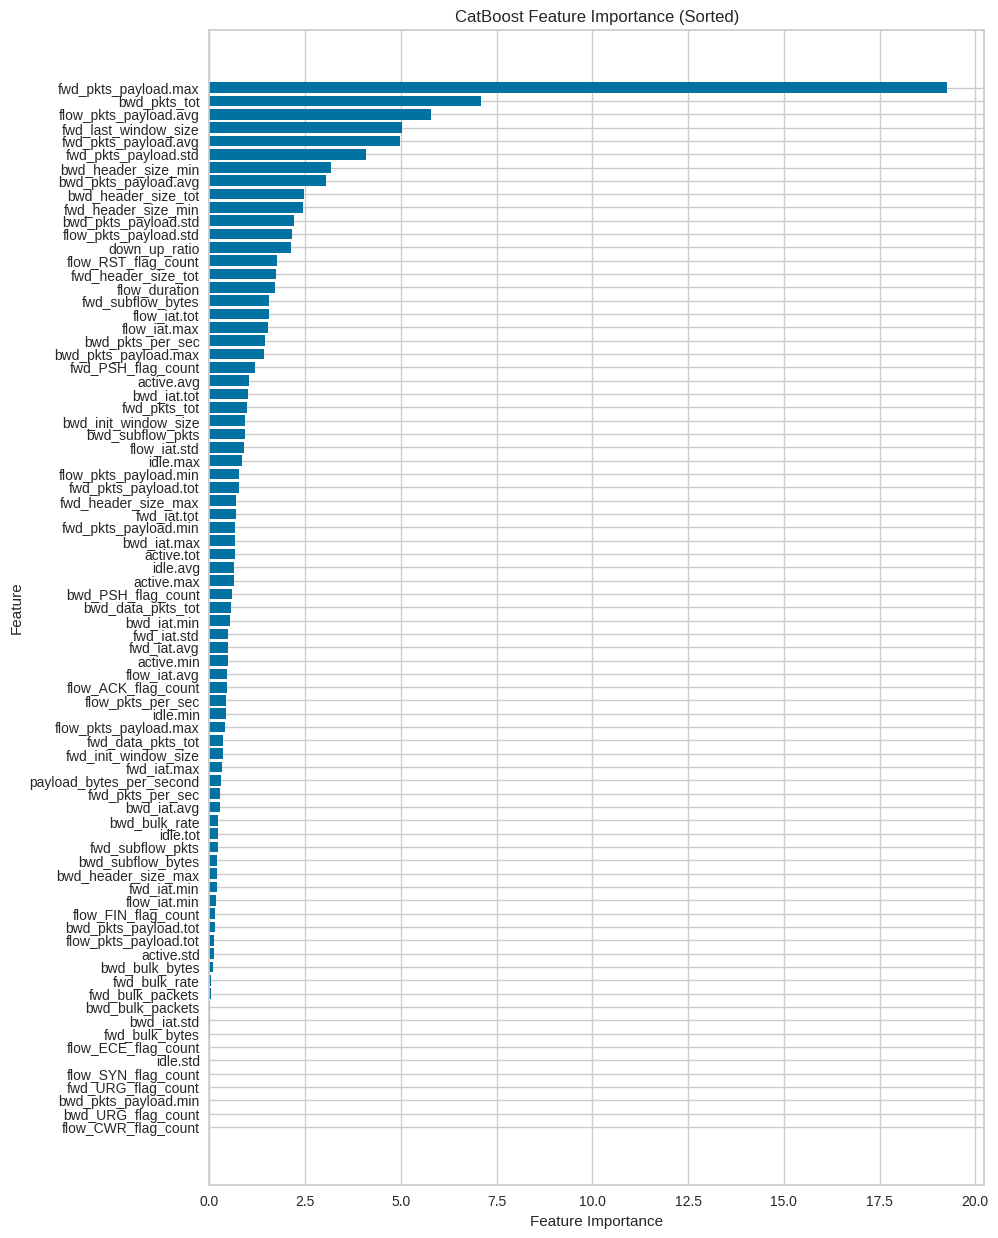

In [17]:
# Retrieve feature importance
feature_importance = model.get_feature_importance(type="FeatureImportance")
feature_names = X_train.columns

# Sort the features and feature importance scores
sorted_indices = np.argsort(feature_importance)
sorted_feature_importance = feature_importance[sorted_indices]
sorted_feature_names = feature_names[sorted_indices]

# Plot the sorted feature importance
plt.figure(figsize=(10, 15))
plt.barh(sorted_feature_names, sorted_feature_importance)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('CatBoost Feature Importance (Sorted)')
plt.show()

Using interventional to stay "true to the model" since we will use this data to do feature reduction and we want also to understand how things work

In [18]:
%%time

explainer = fasttreeshap.TreeExplainer(cat, algorithm='auto', n_jobs=-1) 
sv = explainer(X_train)

CPU times: user 4.19 s, sys: 165 ms, total: 4.35 s
Wall time: 1.49 s


In [19]:
cat.classes_

array(['Benign', 'Bruteforce', 'Bruteforce-XML', 'Probing',
       'XMRIGCC CryptoMiner'], dtype=object)

## Benign shap

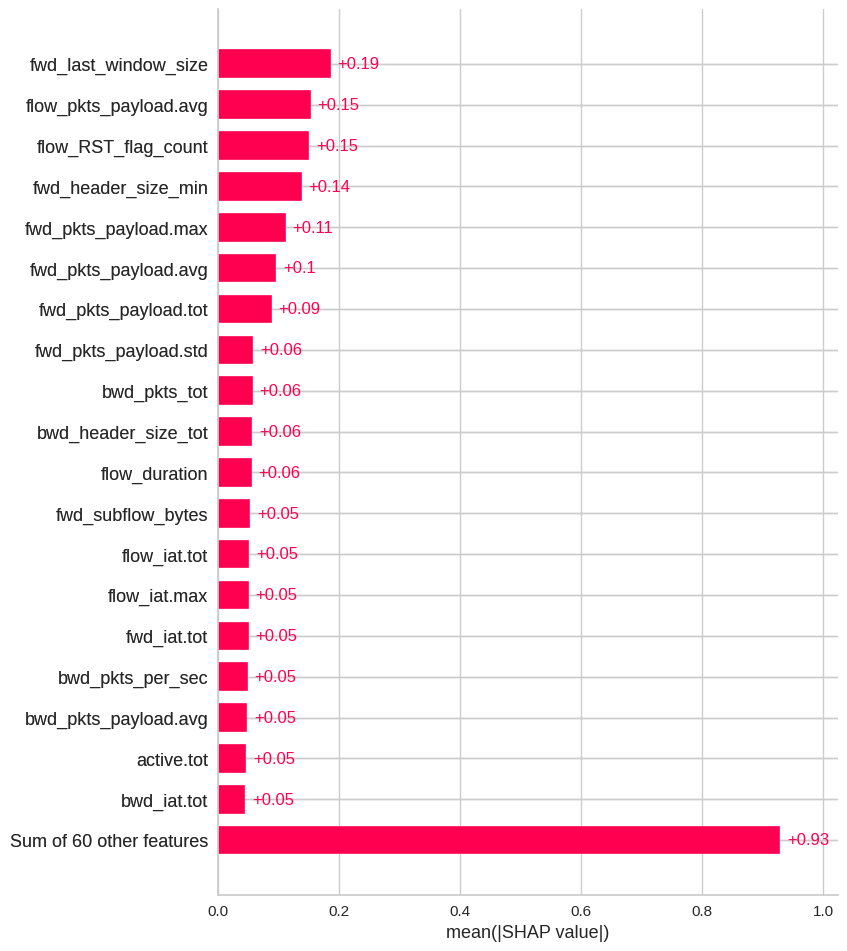

In [20]:
exp = Explanation(sv.values[:,:,0], 
                  sv.base_values[:,0], 
                  data=X_train, 
                  feature_names=x_features)

plots.bar(exp, max_display=20, show=False)
# plt.savefig('tree/shap', dpi=1400, format='pdf', pad_inches=10)
plt.show()

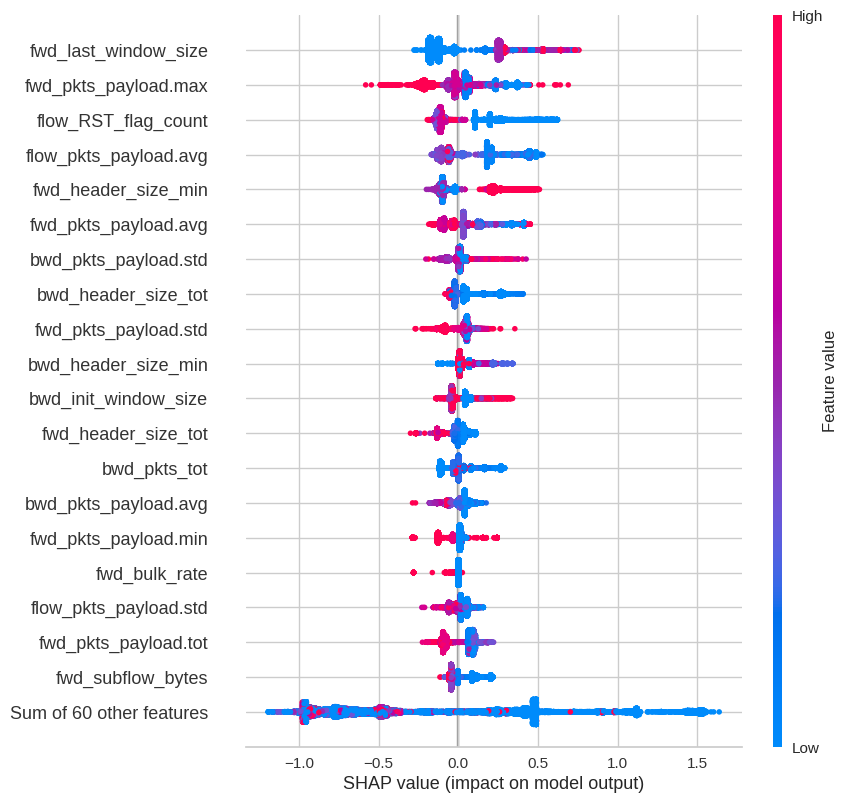

In [21]:
plots.beeswarm(exp,order=exp.abs.max(0),max_display=20)

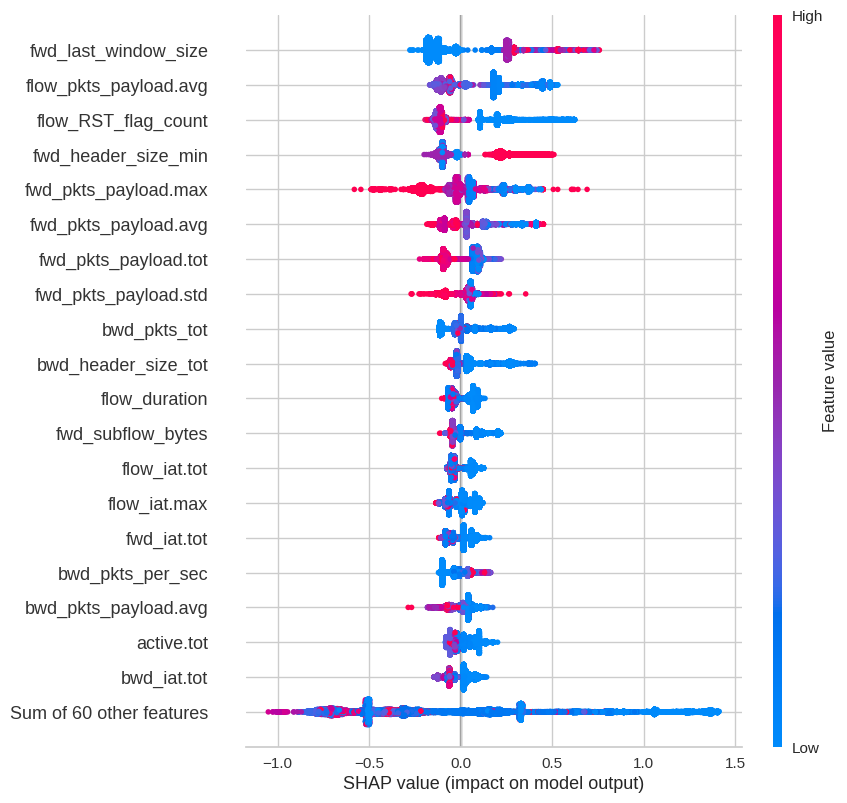

In [22]:
plots.beeswarm(exp,order=exp.abs.mean(0),max_display=20)

## Bruteforce shap

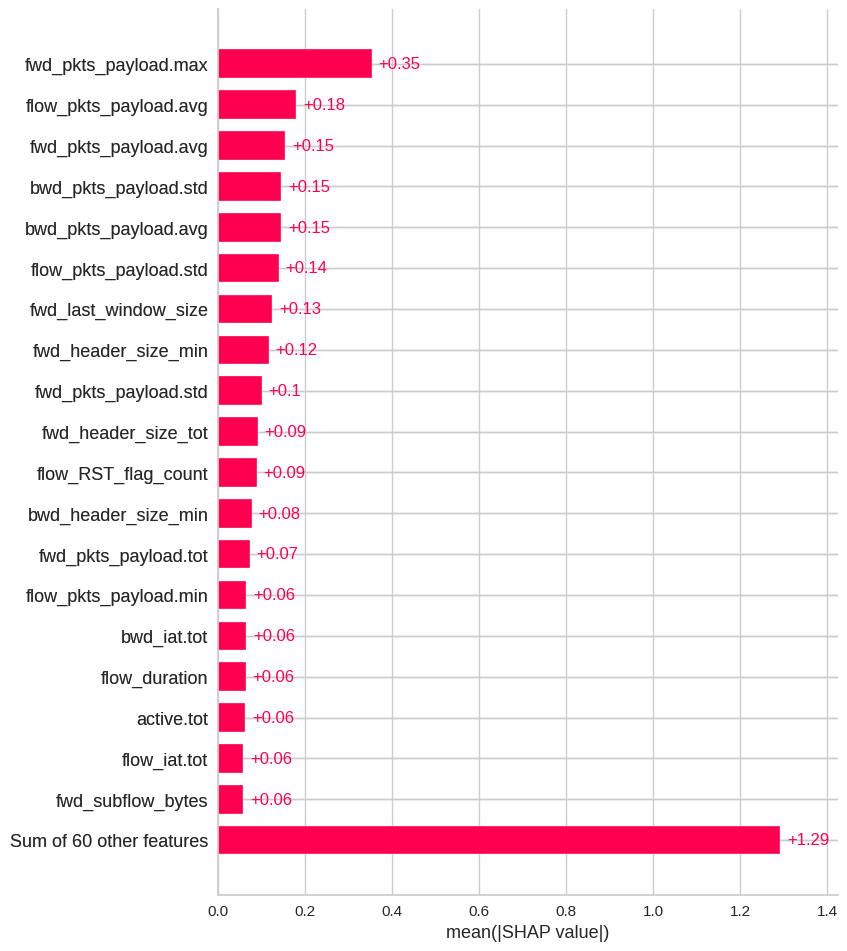

In [23]:
exp = Explanation(sv.values[:,:,1], 
                  sv.base_values[:,1], 
                  data=X_train, 
                  feature_names=x_features)

plots.bar(exp, max_display=20, show=False)
# plt.savefig('tree/shap', dpi=1400, format='pdf', pad_inches=10)

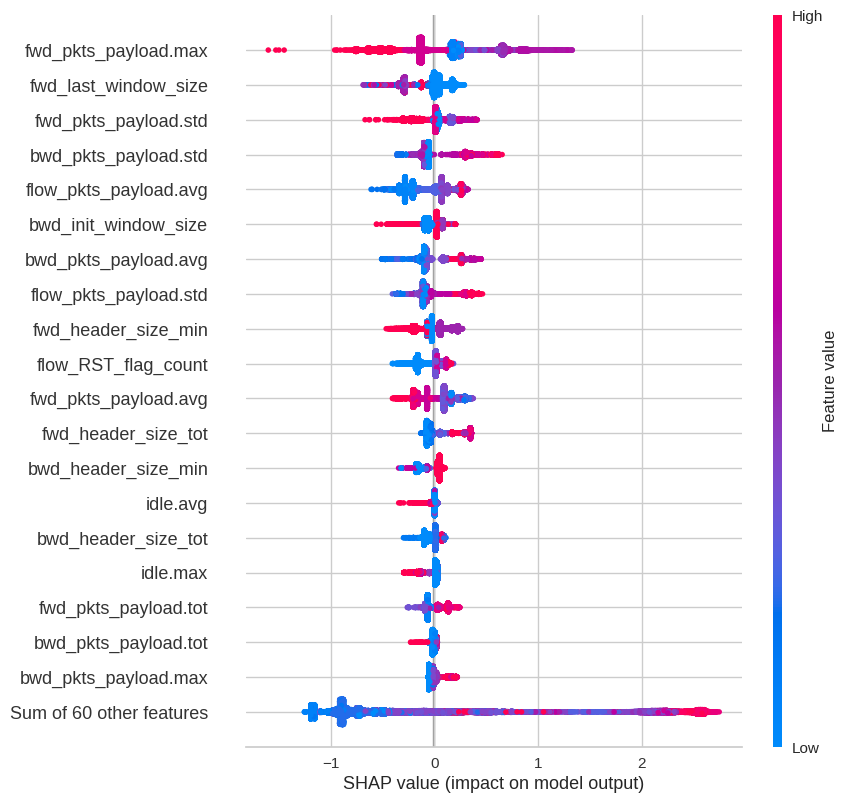

In [24]:
plots.beeswarm(exp,order=exp.abs.max(0),max_display=20)

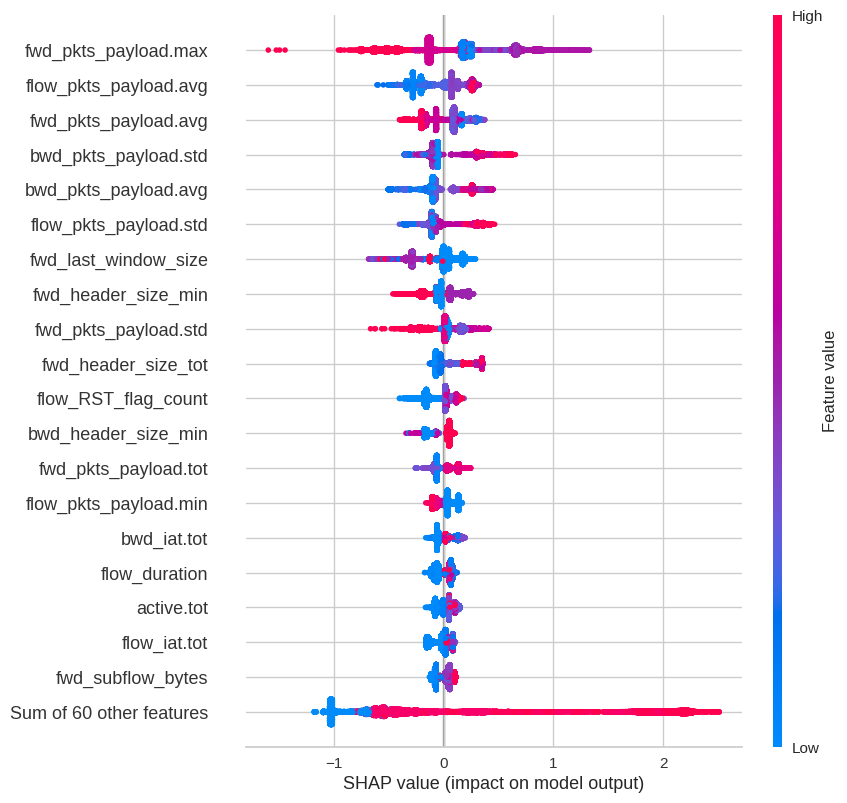

In [25]:
plots.beeswarm(exp,order=exp.abs.mean(0),max_display=20)

## Bruteforce XML shap

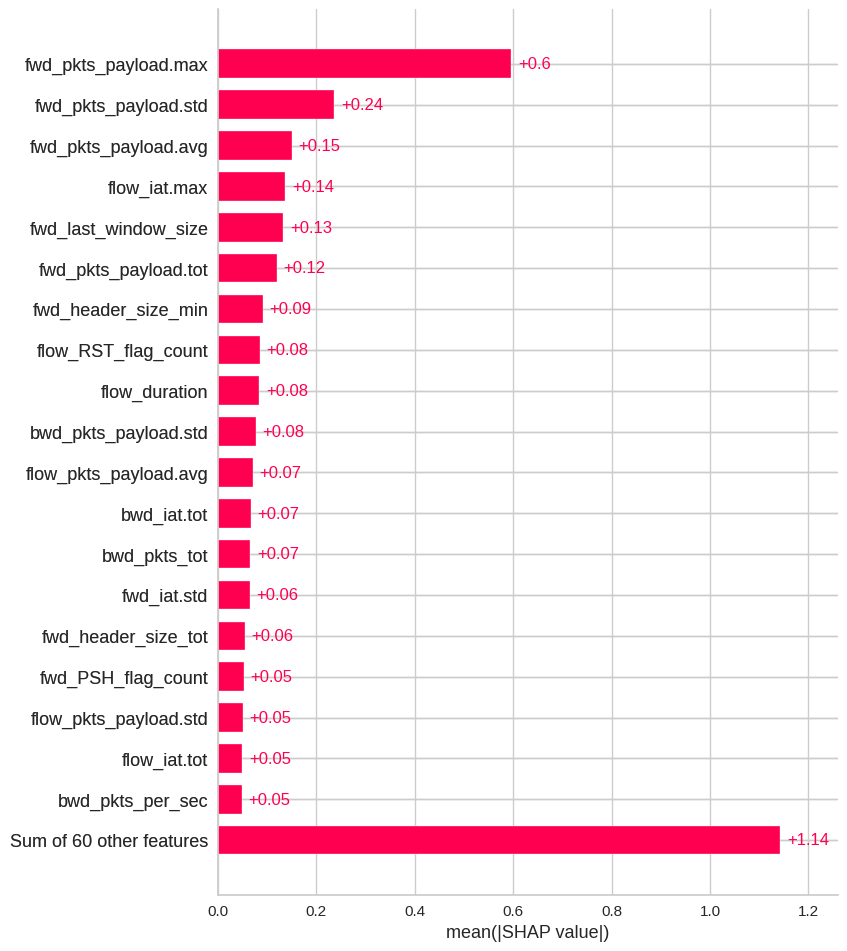

In [26]:
exp = Explanation(sv.values[:,:,2], 
                  sv.base_values[:,2], 
                  data=X_train, 
                  feature_names=x_features)

plots.bar(exp, max_display=20, show=False)
# plt.savefig('tree/shap', dpi=1400, format='pdf', pad_inches=10)

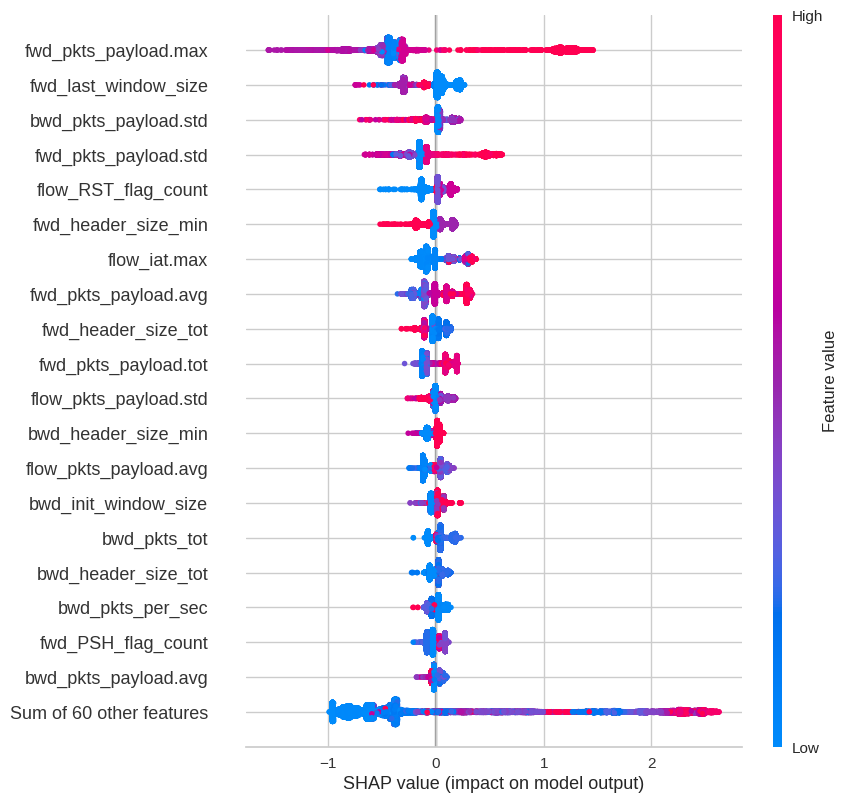

In [27]:
plots.beeswarm(exp,order=exp.abs.max(0),max_display=20)

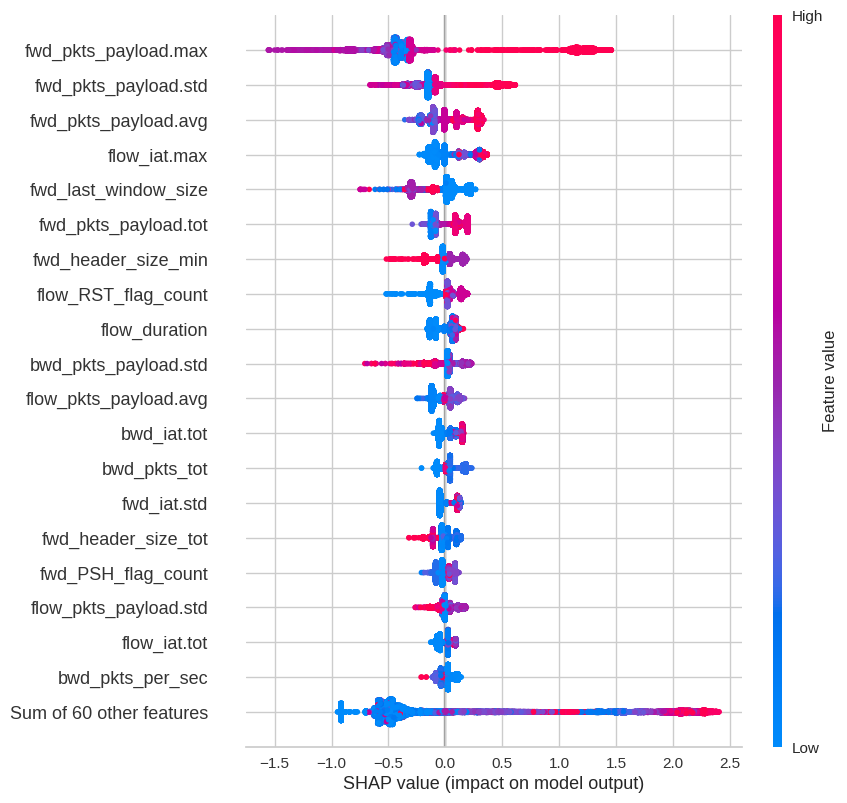

In [28]:
plots.beeswarm(exp,order=exp.abs.mean(0),max_display=20)

## Probing shap

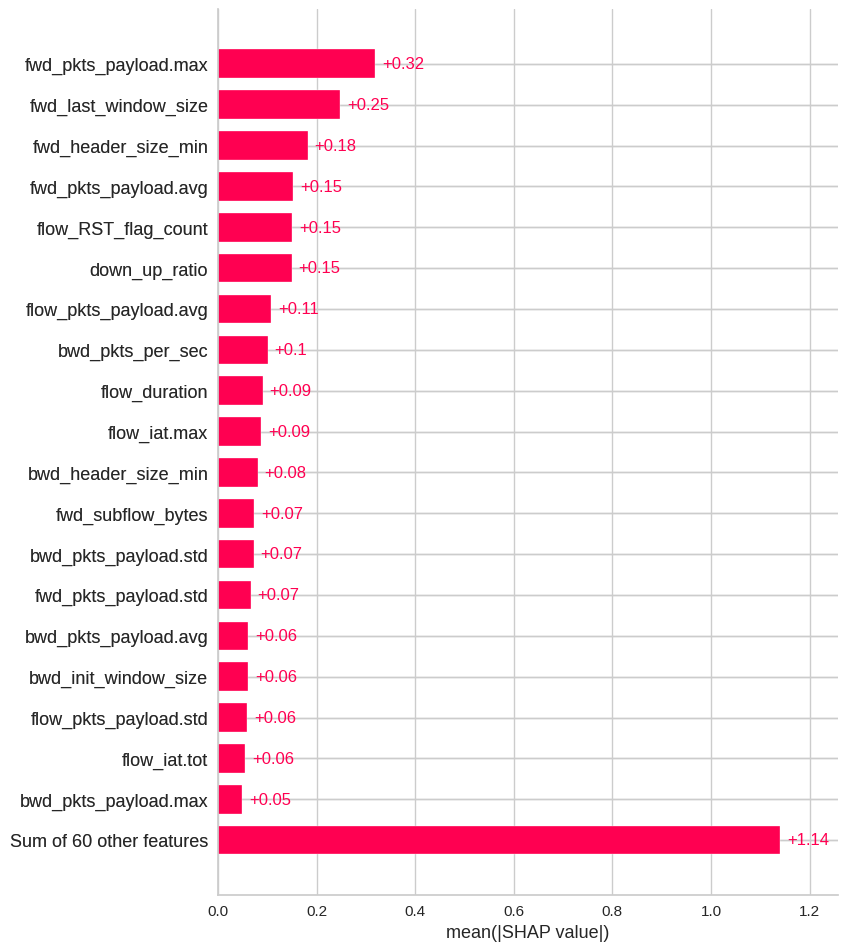

In [29]:
exp = Explanation(sv.values[:,:,3], 
                  sv.base_values[:,3], 
                  data=X_train, 
                  feature_names=x_features)

plots.bar(exp, max_display=20, show=False)
# plt.savefig('tree/shap', dpi=1400, format='pdf', pad_inches=10)

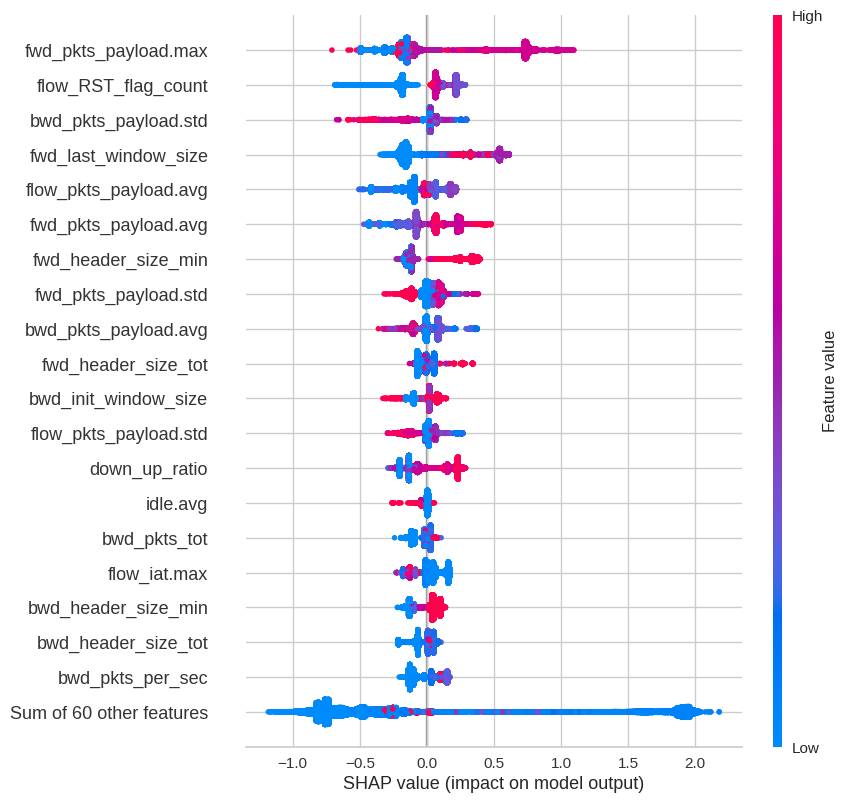

In [30]:
plots.beeswarm(exp,order=exp.abs.max(0),max_display=20)

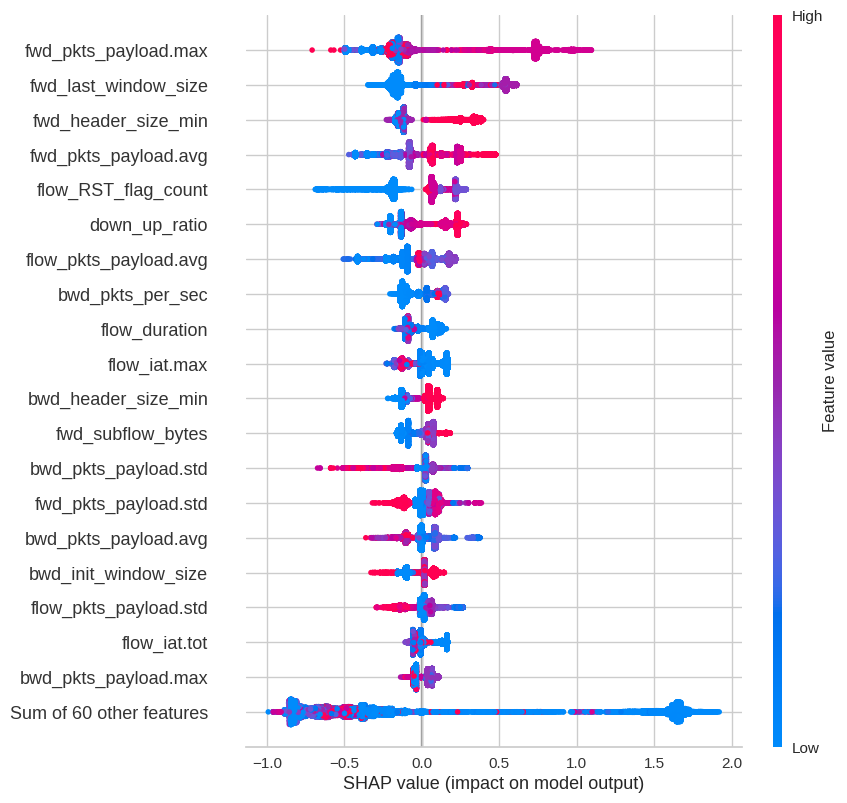

In [31]:
plots.beeswarm(exp,order=exp.abs.mean(0),max_display=20)

## Miner shap

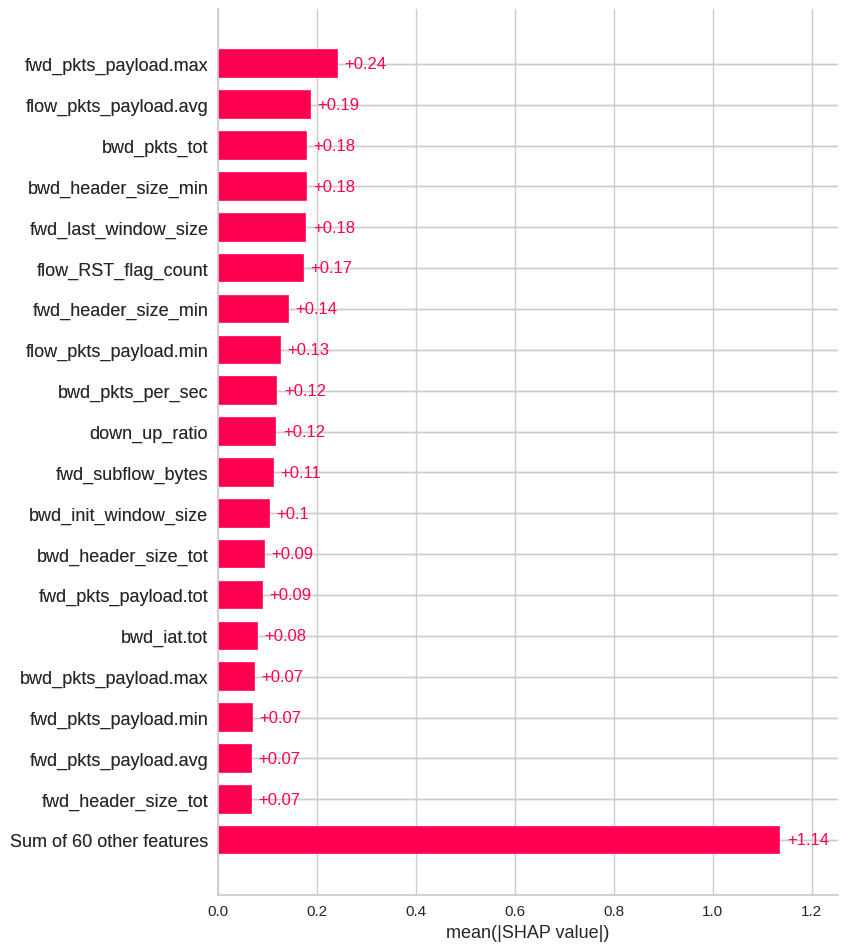

In [32]:
exp = Explanation(sv.values[:,:,4], 
                  sv.base_values[:,4], 
                  data=X_train, 
                  feature_names=x_features)

plots.bar(exp, max_display=20, show=False)
# plt.savefig('tree/shap', dpi=1400, format='pdf', pad_inches=10)

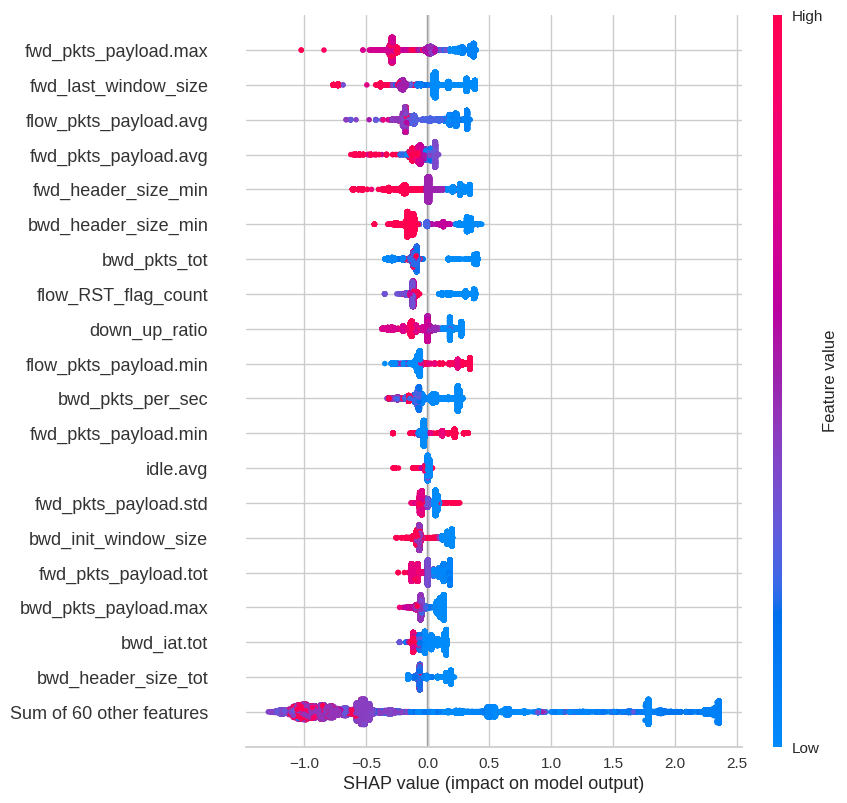

In [33]:
plots.beeswarm(exp,order=exp.abs.max(0),max_display=20)

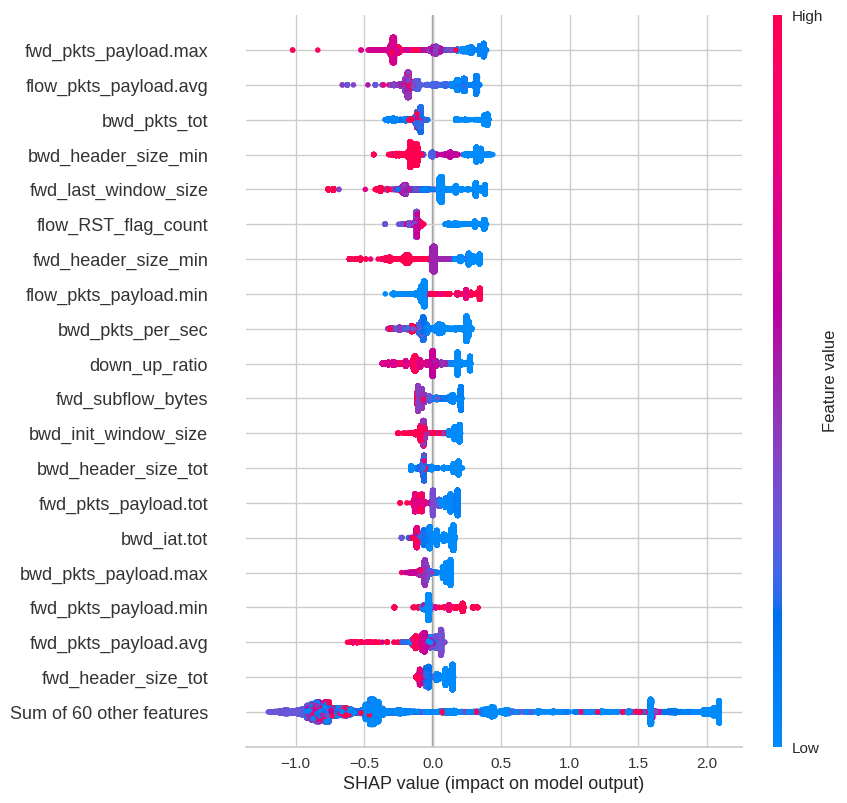

In [34]:
plots.beeswarm(exp,order=exp.abs.mean(0),max_display=20)

## Overall importance

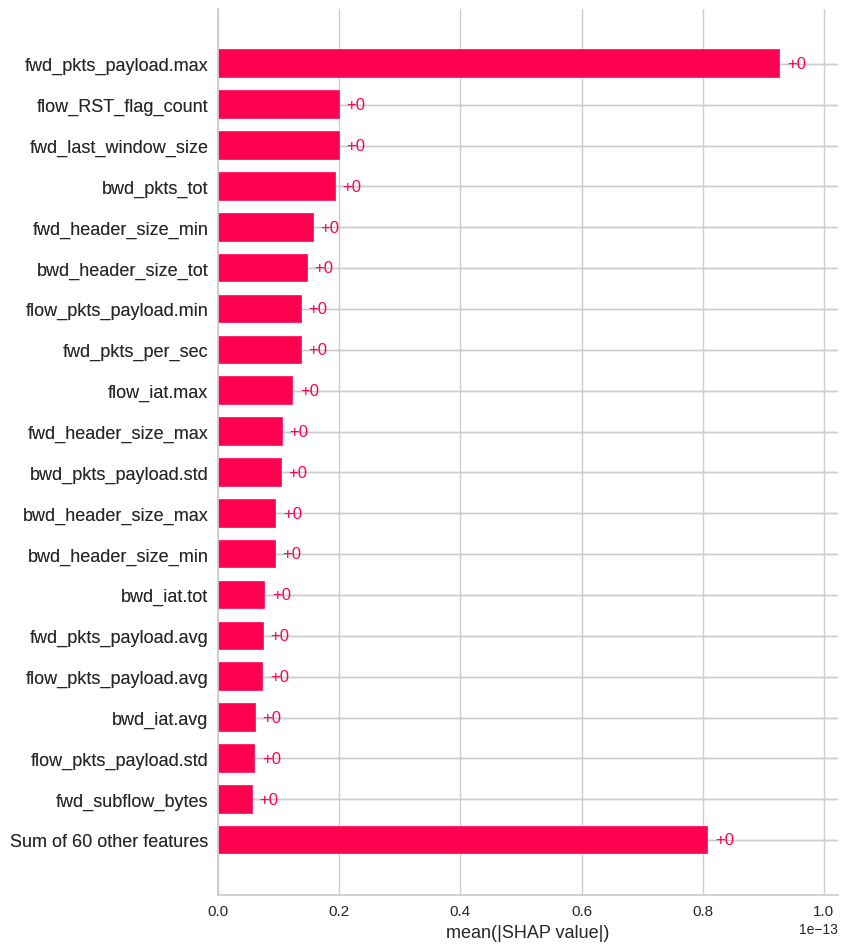

In [35]:
exp = Explanation(sv.values.mean(2), 
                  sv.base_values.mean(1), 
                  data=X_train, 
                  feature_names=X_res.columns)

plots.bar(exp, max_display=20, show=False)
# plt.savefig('tree/shap', dpi=1400, format='pdf', pad_inches=10)
plt.show()

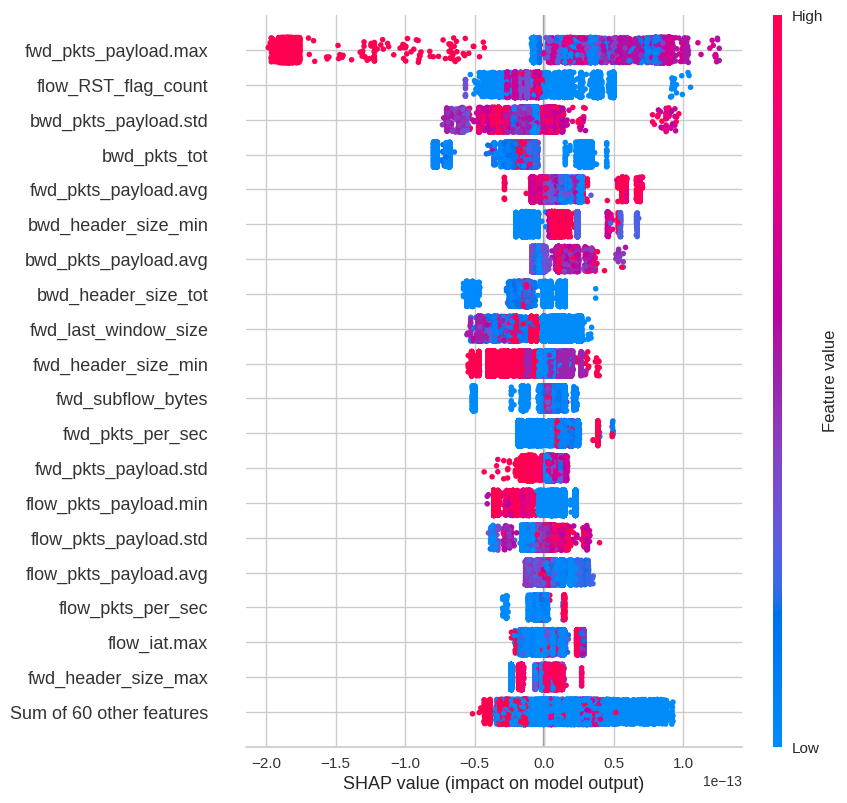

In [36]:
plots.beeswarm(exp,order=exp.abs.max(0),max_display=20)

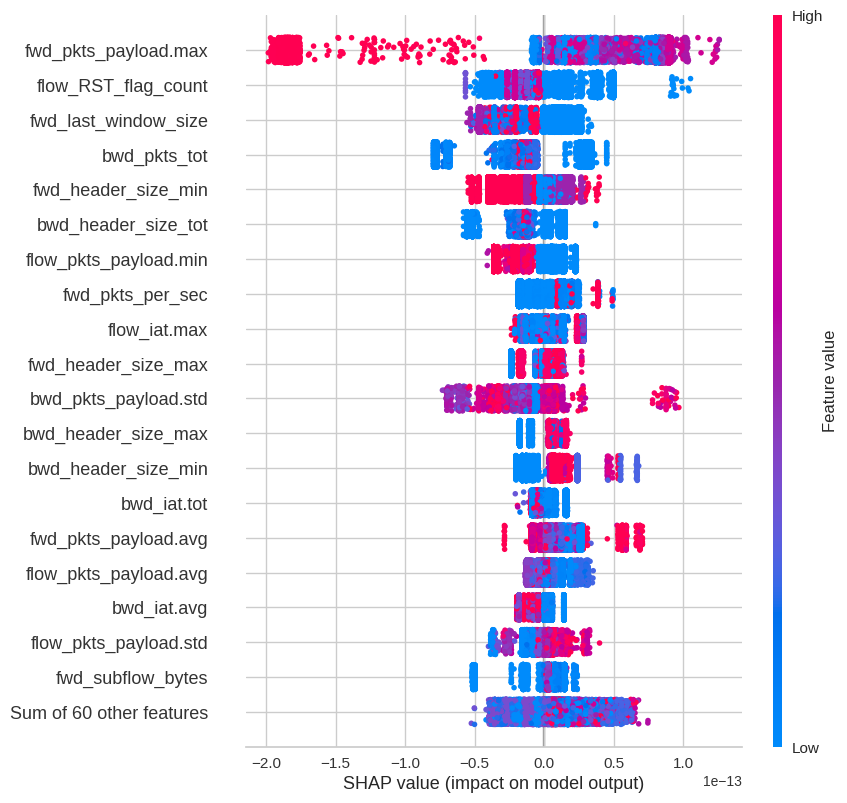

In [37]:
plots.beeswarm(exp,order=exp.abs.mean(0),max_display=20)

# Zero day test

In [38]:
classes = sorted(pd.unique(ds['traffic_category']).tolist())

In [39]:
y_train_attack = y_train.reset_index(drop=True)
y_train_attack = y_train_attack[y_train_attack != 'Bruteforce']
X_train_attack = X_train.reset_index(drop=True)
X_train_attack = X_train_attack.iloc[y_train_attack.index]
cat.fit(X_train_attack, y_train_attack)
y_predicted_train = cat.predict(X_train_attack)
y_predicted_test = cat.predict(X_test)
performanceMetricsDFWeighted(metrics, y_train_attack, y_predicted_train, y_test, y_predicted_test, 'weighted')

0:	learn: 1.1375945	total: 30ms	remaining: 2.37s
1:	learn: 0.9657024	total: 52.6ms	remaining: 2.05s
2:	learn: 0.8386522	total: 85.5ms	remaining: 2.19s
3:	learn: 0.7388731	total: 115ms	remaining: 2.19s
4:	learn: 0.6587619	total: 140ms	remaining: 2.11s
5:	learn: 0.5923468	total: 164ms	remaining: 2.03s
6:	learn: 0.5369388	total: 188ms	remaining: 1.96s
7:	learn: 0.4895400	total: 212ms	remaining: 1.91s
8:	learn: 0.4479157	total: 236ms	remaining: 1.86s
9:	learn: 0.4125082	total: 262ms	remaining: 1.83s
10:	learn: 0.3817451	total: 287ms	remaining: 1.8s
11:	learn: 0.3556090	total: 311ms	remaining: 1.76s
12:	learn: 0.3320238	total: 335ms	remaining: 1.72s
13:	learn: 0.3106204	total: 360ms	remaining: 1.7s
14:	learn: 0.2928820	total: 384ms	remaining: 1.66s
15:	learn: 0.2760918	total: 407ms	remaining: 1.63s
16:	learn: 0.2614137	total: 433ms	remaining: 1.6s
17:	learn: 0.2481888	total: 459ms	remaining: 1.58s
18:	learn: 0.2367742	total: 485ms	remaining: 1.55s
19:	learn: 0.2261805	total: 509ms	remaining

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


,Measure,Train,Test
0,ACCURACY,0.964438,0.769029
1,PRECISION,0.966621,0.662825
2,RECALL,0.964438,0.769029
3,F1 SCORE,0.963686,0.703887


unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.


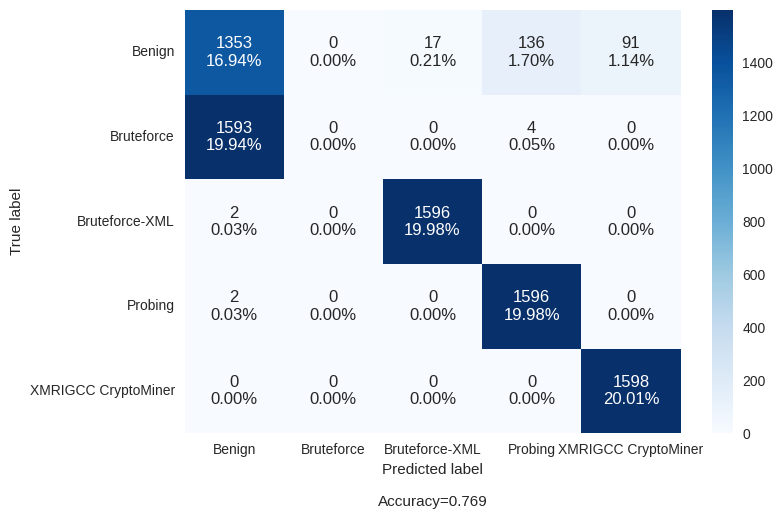

In [40]:
# Show the confusion matrix
cf = metrics.confusion_matrix(y_test,y_predicted_test)
categories = pd.unique(classes)
make_confusion_matrix(cf, 
                      categories=categories,
                      cmap='Blues')

In [41]:
y_train_attack = y_train.reset_index(drop=True)
y_train_attack = y_train_attack[y_train_attack != 'Bruteforce-XML']
X_train_attack = X_train.reset_index(drop=True)
X_train_attack = X_train_attack.iloc[y_train_attack.index]
cat.fit(X_train_attack, y_train_attack)
y_predicted_train = cat.predict(X_train_attack)
y_predicted_test = cat.predict(X_test)
performanceMetricsDFWeighted(metrics, y_train_attack, y_predicted_train, y_test, y_predicted_test, 'weighted')

0:	learn: 1.1445800	total: 31ms	remaining: 2.45s
1:	learn: 0.9765320	total: 62.9ms	remaining: 2.45s
2:	learn: 0.8502343	total: 101ms	remaining: 2.58s
3:	learn: 0.7498557	total: 136ms	remaining: 2.58s
4:	learn: 0.6698507	total: 171ms	remaining: 2.57s
5:	learn: 0.6032952	total: 207ms	remaining: 2.55s
6:	learn: 0.5473508	total: 243ms	remaining: 2.53s
7:	learn: 0.4993866	total: 281ms	remaining: 2.53s
8:	learn: 0.4582350	total: 316ms	remaining: 2.5s
9:	learn: 0.4233811	total: 355ms	remaining: 2.48s
10:	learn: 0.3931449	total: 392ms	remaining: 2.46s
11:	learn: 0.3665625	total: 428ms	remaining: 2.42s
12:	learn: 0.3427527	total: 463ms	remaining: 2.39s
13:	learn: 0.3213609	total: 502ms	remaining: 2.37s
14:	learn: 0.3032418	total: 539ms	remaining: 2.33s
15:	learn: 0.2861610	total: 574ms	remaining: 2.29s
16:	learn: 0.2712165	total: 611ms	remaining: 2.26s
17:	learn: 0.2584646	total: 647ms	remaining: 2.23s
18:	learn: 0.2473605	total: 685ms	remaining: 2.2s
19:	learn: 0.2369771	total: 722ms	remaining

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


,Measure,Train,Test
0,ACCURACY,0.962992,0.768653
1,PRECISION,0.965098,0.647066
2,RECALL,0.962992,0.768653
3,F1 SCORE,0.962169,0.697225


unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.


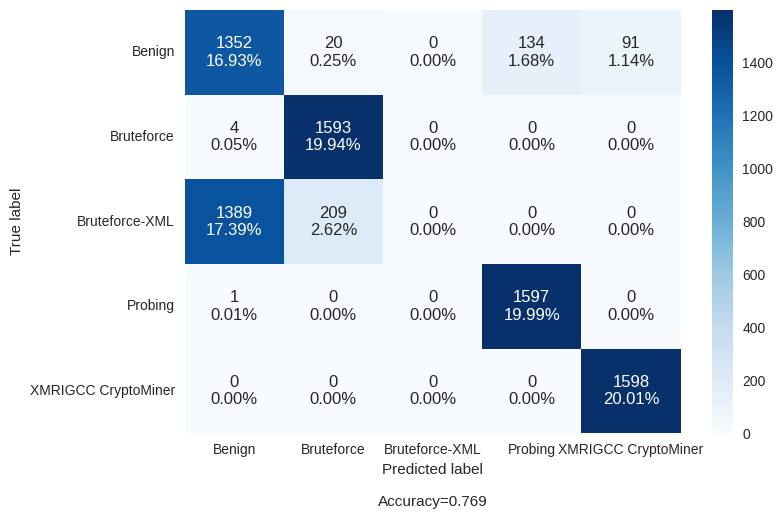

In [42]:
# Show the confusion matrix
cf = metrics.confusion_matrix(y_test,y_predicted_test)
categories = pd.unique(classes)
make_confusion_matrix(cf, 
                      categories=categories,
                      cmap='Blues')

In [43]:
y_train_attack = y_train.reset_index(drop=True)
y_train_attack = y_train_attack[y_train_attack != 'Probing']
X_train_attack = X_train.reset_index(drop=True)
X_train_attack = X_train_attack.iloc[y_train_attack.index]
cat.fit(X_train_attack, y_train_attack)
y_predicted_train = cat.predict(X_train_attack)
y_predicted_test = cat.predict(X_test)
performanceMetricsDFWeighted(metrics, y_train_attack, y_predicted_train, y_test, y_predicted_test, 'weighted')

0:	learn: 1.1285027	total: 32.7ms	remaining: 2.58s
1:	learn: 0.9500085	total: 64.7ms	remaining: 2.52s
2:	learn: 0.8174118	total: 98.1ms	remaining: 2.52s
3:	learn: 0.7132025	total: 134ms	remaining: 2.54s
4:	learn: 0.6293673	total: 167ms	remaining: 2.51s
5:	learn: 0.5599493	total: 201ms	remaining: 2.48s
6:	learn: 0.5018551	total: 238ms	remaining: 2.48s
7:	learn: 0.4518824	total: 275ms	remaining: 2.47s
8:	learn: 0.4088451	total: 309ms	remaining: 2.44s
9:	learn: 0.3720267	total: 345ms	remaining: 2.41s
10:	learn: 0.3402728	total: 380ms	remaining: 2.38s
11:	learn: 0.3121406	total: 416ms	remaining: 2.36s
12:	learn: 0.2872389	total: 452ms	remaining: 2.33s
13:	learn: 0.2649978	total: 488ms	remaining: 2.3s
14:	learn: 0.2455736	total: 522ms	remaining: 2.26s
15:	learn: 0.2280197	total: 556ms	remaining: 2.22s
16:	learn: 0.2127455	total: 591ms	remaining: 2.19s
17:	learn: 0.1989402	total: 628ms	remaining: 2.16s
18:	learn: 0.1870454	total: 662ms	remaining: 2.13s
19:	learn: 0.1761460	total: 698ms	remai

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


,Measure,Train,Test
0,ACCURACY,0.982787,0.783550
1,PRECISION,0.983343,0.680463
2,RECALL,0.982787,0.783550
3,F1 SCORE,0.982662,0.717888


unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.


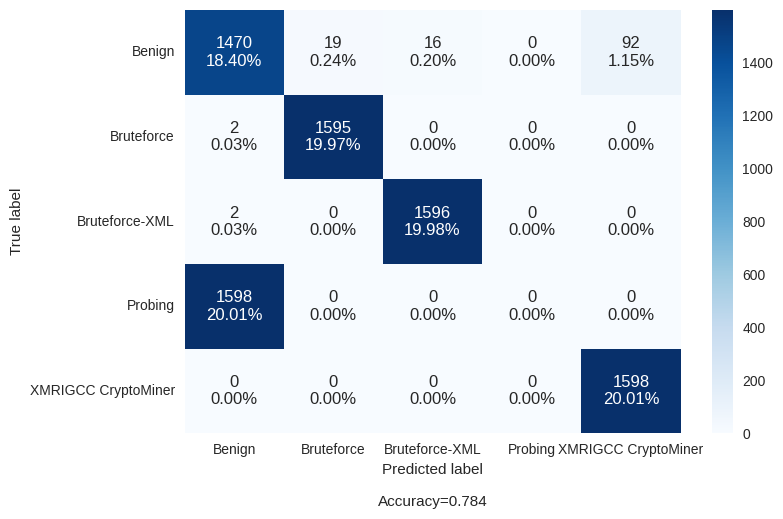

In [44]:
# Show the confusion matrix
cf = metrics.confusion_matrix(y_test,y_predicted_test)
categories = pd.unique(classes)
make_confusion_matrix(cf, 
                      categories=categories,
                      cmap='Blues')

In [45]:
y_train_attack = y_train.reset_index(drop=True)
y_train_attack = y_train_attack[y_train_attack != 'XMRIGCC CryptoMiner']
X_train_attack = X_train.reset_index(drop=True)
X_train_attack = X_train_attack.iloc[y_train_attack.index]
cat.fit(X_train_attack, y_train_attack)
y_predicted_train = cat.predict(X_train_attack)
y_predicted_test = cat.predict(X_test)
performanceMetricsDFWeighted(metrics, y_train_attack, y_predicted_train, y_test, y_predicted_test, 'weighted')

0:	learn: 1.1290347	total: 40.4ms	remaining: 3.19s
1:	learn: 0.9569697	total: 77.2ms	remaining: 3.01s
2:	learn: 0.8248854	total: 123ms	remaining: 3.15s
3:	learn: 0.7231503	total: 163ms	remaining: 3.1s
4:	learn: 0.6399678	total: 200ms	remaining: 3s
5:	learn: 0.5707024	total: 237ms	remaining: 2.92s
6:	learn: 0.5131677	total: 272ms	remaining: 2.83s
7:	learn: 0.4646578	total: 306ms	remaining: 2.75s
8:	learn: 0.4231860	total: 343ms	remaining: 2.71s
9:	learn: 0.3873171	total: 379ms	remaining: 2.65s
10:	learn: 0.3555587	total: 415ms	remaining: 2.6s
11:	learn: 0.3286492	total: 451ms	remaining: 2.56s
12:	learn: 0.3045357	total: 487ms	remaining: 2.51s
13:	learn: 0.2833102	total: 524ms	remaining: 2.47s
14:	learn: 0.2646133	total: 558ms	remaining: 2.42s
15:	learn: 0.2479605	total: 593ms	remaining: 2.37s
16:	learn: 0.2330410	total: 629ms	remaining: 2.33s
17:	learn: 0.2200013	total: 664ms	remaining: 2.29s
18:	learn: 0.2084676	total: 700ms	remaining: 2.25s
19:	learn: 0.1979144	total: 736ms	remaining:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


,Measure,Train,Test
0,ACCURACY,0.973867,0.778167
1,PRECISION,0.975453,0.674532
2,RECALL,0.973867,0.778167
3,F1 SCORE,0.973631,0.712896


unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.


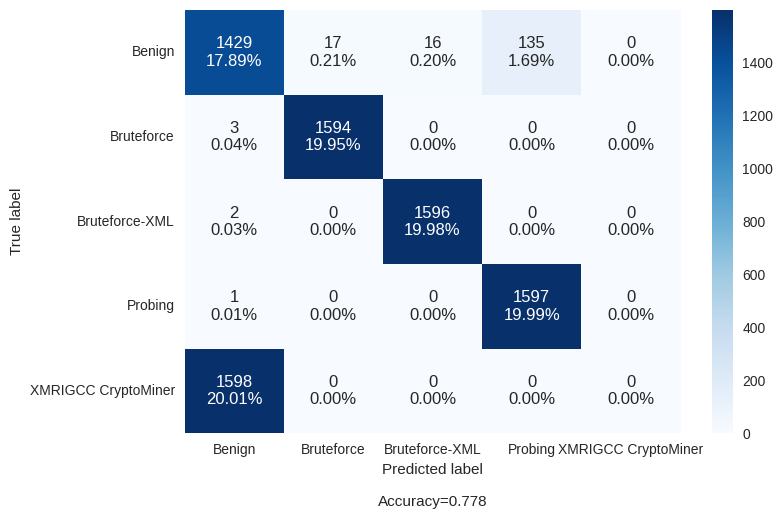

In [46]:
# Show the confusion matrix
cf = metrics.confusion_matrix(y_test,y_predicted_test)
categories = pd.unique(classes)
make_confusion_matrix(cf, 
                      categories=categories,
                      cmap='Blues')